In [66]:
data_path = '/home/yigit/projects/is/data/'
folder_path = f'{data_path}data_raw/'

time_steps = 400

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

import rospy


def extract_g_p_t(file_path):
    states = np.load(file_path, allow_pickle=True)
    states = states[:, [0,1,2,3,-2]]  # 0:x, 1:y, 2:px, 3:py, -2:t
    t, _ = states.shape
    timed_states = []
    
    for i in range(t-1):  # if 2 timestamps equal, skip one
        if states[i, -1]==states[i+1, -1]:
            continue
        else:
            timed_states.append(states[i])
    
    states = np.array(timed_states)
    t, _ = states.shape
    for i in range(t):
        states[i, -1] = rospy.Time.to_sec(states[i, -1])
    
#     t_diff = states[-1, -1] - states[0, -1]
#     states[:, -1] = (states[:, -1] - states[0, -1]) / t_diff  # mapping timestamps to unit interval [0,1]
    states[:, -1] = (states[:, -1] - states[0, -1])  # starting from t=0
#     print(states)
    return states.astype(float)


def rotate(states, rad):
    c, s = np.cos(rad), np.sin(rad)
    j = np.matrix([[c, s], [-s, c]])
    rot_states = np.zeros_like(states)
    rot_states[:, :4] = np.concatenate((np.dot(states[:, :2], j), np.dot(states[:, 2:4], j)), axis=1)
    rot_states[:, -1] = states[:, -1].ravel()

    return rot_states


def polyfit(states):
    t_orig, d = states.shape
    t = np.linspace(0, states[-1, -1], time_steps)
    
    cont_states = np.zeros((time_steps, d))
    
    for i in range(d-1):  # fit a spline on each dim
        p = np.poly1d(np.polyfit(states[:, -1], states[:, i], 14))
        cont_states[:, i] = p(t)
    cont_states[:, -1] = t
        
    return cont_states


def fit_spline(states):
    t_orig, d = states.shape
    t = np.linspace(0, 1, time_steps)
    
    cont_states = np.zeros((time_steps, d))
    
    for i in range(d-1):  # fit a spline on each dim
        spl = UnivariateSpline(states[:, -1], states[:, i])
        spl.set_smoothing_factor(1.0)
        cont_states[:, i] = spl(t)
    cont_states[:, -1] = t
        
    return cont_states


def interpolate(states):
    t_orig, d = states.shape
    
    t = np.linspace(0, 1, time_steps)
    tp = np.linspace(0, 1, t_orig)
    
    cont_states = np.zeros((time_steps, d))
    
    for i in range(d):  # interpolation on each dim
        cont_states[:, i] = np.interp(t, tp, states[:, i])
        
    return cont_states


def egocentricize(states):
    ego_states = np.zeros_like(states)
    goal_pose = states[-1, :2]
    for i in range(states.shape[0]):
        states[i, :2] = goal_pose - states[i, :2]
        
    return states


def calculate_vel(states):
    t, d = states.shape
    vel_states = np.zeros((t, d+1))  # remove t, place vx, vy. Therefore d-1+2=d+1
    vel_states[:, :4] = states[:, :4]
    for i, state in enumerate(states):
        if i==len(states)-2:
            break

        next_state = states[i+1]
        vx, vy = (next_state[:2] - state[:2]) / (next_state[-1] - state[-1])
#         print(f's: {state[:2]}, ns: {next_state[:2]}, t: {state[-1]}, nt: {next_state[-1]}, vx: {vx}, vy: {vy}')
        vel_states[i, -2:] = [vx, vy]
        
    vel_states[-1, -2:] = [0, 0]

    return vel_states


def plot_trajectories(trajectories):
    num_trajs = trajectories.shape[0]
    for i in range(num_trajs):
        plt.plot(trajectories[i, :, 0], trajectories[i, :, 1])
    
    print(f'Number of Trajectories: {num_trajs}')
    plt.savefig("s.svg", format="svg", dpi=1200)
    plt.show()

Number of Trajectories: 1300


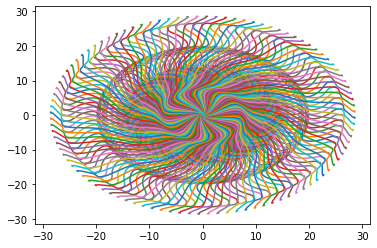

In [164]:
import os


trajectories = []
tr_plot = []
timpos = []

for filename in os.listdir(folder_path):
    f = os.path.join(folder_path, filename)
    
    # checking if it is a file
    if os.path.isfile(f) and f.endswith('npy'):
        timed_poses = extract_g_p_t(f)
        timpos.append(timed_poses)
        cont_timed_poses = egocentricize(polyfit(timed_poses))
        poses_with_vel = calculate_vel(cont_timed_poses)
        np.save(f"{data_path}/processed_states/{filename.strip('_states.npy')}_rot_0.npy", poses_with_vel)
        trajectories.append(poses_with_vel)
        tr_plot.append(poses_with_vel)
        
        num_reps = 99
        angles = np.linspace(2*np.pi/num_reps, 2*np.pi, num=num_reps, endpoint=False)  # 99rot+1orig=100 reps per traj
        for rad in angles:
            r_timed_poses = rotate(timed_poses, rad)
            timpos.append(r_timed_poses)
            r_cont_timed_poses = egocentricize(polyfit(r_timed_poses))
            r_poses_with_vel = calculate_vel(r_cont_timed_poses)
            np.save(f"{data_path}/processed_states/{filename.strip('_states.npy')}_rot_{rad}.npy", r_poses_with_vel)
            trajectories.append(r_poses_with_vel)

trajectories = np.array(trajectories)
tr_plot = np.array(tr_plot)
plot_trajectories(trajectories)

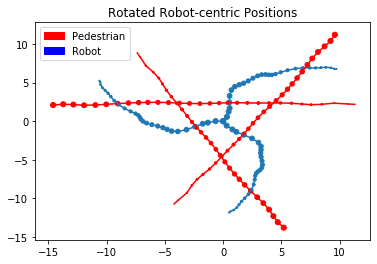

In [178]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Pedestrian')
blue_patch = mpatches.Patch(color='blue', label='Robot')


ids = np.linspace(0, 399, 30, dtype=int)
# print(trajectories[0, ids, :2])
# np.savetxt('/home/yigit/Desktop/0.txt', trajectories[0])
sizes = ids/15

tplot = 1100

plt.plot(trajectories[tplot, ids, 0], trajectories[tplot, ids, 1], color='#1f77b4', zorder=2)
plt.scatter(trajectories[tplot, ids, 0], trajectories[tplot, ids, 1], sizes, color='#1f77b4', zorder=1)
plt.plot(trajectories[tplot, ids, 2], trajectories[tplot, ids, 3], color='red', zorder=2)
plt.scatter(trajectories[tplot, ids, 2], trajectories[tplot, ids, 3], sizes, color='red', zorder=1)

tplot = 1133

plt.plot(trajectories[tplot, ids, 0], trajectories[tplot, ids, 1], color='#1f77b4', zorder=2)
plt.scatter(trajectories[tplot, ids, 0], trajectories[tplot, ids, 1], sizes, color='#1f77b4', zorder=1)
plt.plot(trajectories[tplot, ids, 2], trajectories[tplot, ids, 3], color='red', zorder=2)
plt.scatter(trajectories[tplot, ids, 2], trajectories[tplot, ids, 3], sizes, color='red', zorder=1)

tplot = 1166

plt.plot(trajectories[tplot, ids, 0], trajectories[tplot, ids, 1], color='#1f77b4', zorder=2)
plt.scatter(trajectories[tplot, ids, 0], trajectories[tplot, ids, 1], sizes, color='#1f77b4', zorder=1)
plt.plot(trajectories[tplot, ids, 2], trajectories[tplot, ids, 3], color='red', zorder=2)
plt.scatter(trajectories[tplot, ids, 2], trajectories[tplot, ids, 3], sizes, color='red', zorder=1)

plt.legend(handles=[red_patch, blue_patch])
plt.title("Rotated Robot-centric Positions")
# plt.savefig("rcp.svg", format="svg", dpi=1200)
plt.savefig('rot_rcp.png', dpi=200)
plt.show()

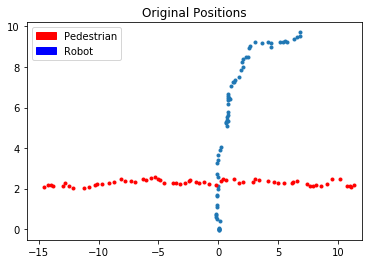

In [173]:
plt.plot(timpos[1100][:, 1], timpos[1100][:, 0], '.')
plt.plot(timpos[1100][:, 2], timpos[1100][:, 3], 'r.')
plt.xlim([-16, 12])
plt.legend(handles=[red_patch, blue_patch])
plt.title("Original Positions")
plt.savefig('raw_rcp.png', dpi=200)
plt.show()